# Primary Vertex check

The discrepancy we see in the transverse impact parameter might come fromt the fact, that the primary vertices are off. 

In [1]:
import uproot 
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator, FuncFormatter

import gc

from sklearn.metrics import roc_curve, auc, roc_auc_score
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm

%load_ext autoreload
%autoreload 2

In [2]:
from cycler import cycler
import matplotlib

# Set the color cycle
# https://coolors.co/542344-f68e5f-e5e059-007ea7-98e2c6
plt.rc('axes', prop_cycle=cycler('color', ['#73b06f', '#e6701b', '#007090', '#e7298a', '#802392', '#ffad08', '#56b4e9']))
matplotlib.rcParams["font.family"] = "serif"
# Set font sizes
matplotlib.rcParams.update(
    {
        "font.size": 14,  # General font size
    }
)

In [3]:
path_fullsim = "/eos/experiment/fcc/ee/datasets/CLD_fullsim_tagging_debug_tracks/with_fixesPV/Huu.root"
path_fastsim = "/eos/experiment/fcc/ee/jet_flavour_tagging/winter2023/samples_v7/CLD_Huu_debug_tracks/stage1_Huu.root" #Huu.root"

In [4]:
def load_data(file_name, stop=250000, key='tree;1'):
    file = uproot.open(file_name)
    tree = file[key]
    data = tree.arrays(library="np", entry_start=0, entry_stop=stop)
    return data

In [5]:
dic = {"fast": load_data(path_fastsim, stop=50000, key='events;1'), "full": load_data(path_fullsim, stop=50000, key="JetConstituentObservables;1"),} # 100k, 500k

In [6]:
dic["full"].keys()

dict_keys(['pfcand_erel_log', 'pfcand_thetarel', 'pfcand_phirel', 'pfcand_e', 'pfcand_p', 'pfcand_type', 'pfcand_charge', 'pfcand_isEl', 'pfcand_isMu', 'pfcand_isGamma', 'pfcand_isChargedHad', 'pfcand_isNeutralHad', 'pfcand_dndx', 'pfcand_tof', 'pfcand_cov_omegaomega', 'pfcand_cov_tanLambdatanLambda', 'pfcand_cov_phiphi', 'pfcand_cov_d0d0', 'pfcand_cov_z0z0', 'pfcand_cov_d0z0', 'pfcand_cov_phid0', 'pfcand_cov_tanLambdaz0', 'pfcand_cov_d0omega', 'pfcand_cov_d0tanLambda', 'pfcand_cov_phiomega', 'pfcand_cov_phiz0', 'pfcand_cov_phitanLambda', 'pfcand_cov_omegaz0', 'pfcand_cov_omegatanLambda', 'pfcand_d0', 'pfcand_z0', 'pfcand_Sip2dVal', 'pfcand_Sip2dSig', 'pfcand_Sip3dVal', 'pfcand_Sip3dSig', 'pfcand_JetDistVal', 'pfcand_JetDistSig', 'jet_PV_x', 'jet_PV_y', 'jet_PV_z', 'jet_PV_id', 'jet_MCPV_x', 'jet_MCPV_y', 'jet_MCPV_z'])

In [7]:
def select_unqiue(dic):
    # pv are saved twice in the full sim file, so I need to drop one of them
    ids, ind = np.unique(dic["full"]["jet_PV_id"], return_index=True)
    for key in dic.keys(): # fast, full
        if key == "fast":
            continue
        for k in dic[key].keys():
            print(k)
            dic[key][k] = dic[key][k][ind]
    return dic
    

In [8]:
#dic = select_unqiue(dic)

In [9]:
dic["fast"]["jet_PV_x"].shape, dic["full"]["jet_PV_x"].shape

((50000,), (50000,))

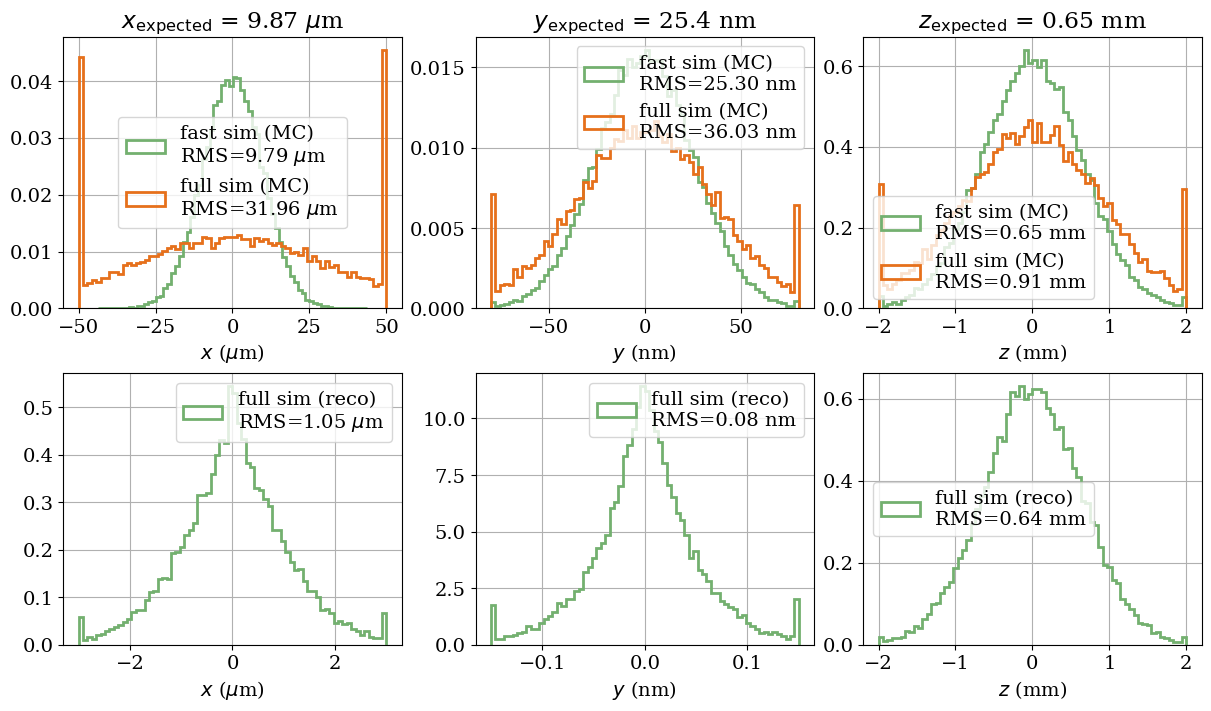

In [11]:
keys = ["jet_PV_x", "jet_PV_y", "jet_PV_z"]
MCkeys = ["jet_MCPV_x", "jet_MCPV_y", "jet_MCPV_z"]
xlabels = [r"$x$ ($\mu$m)", "$y$ (nm)", "$z$ (mm)"]
units = ["$\mu$m", "nm", "mm"]
legend_labels = {"fast": "(MC)", "full": "(reco)"}
ranges = {"full":{
    "jet_PV_x": (-3, 3), #(-3e-3, 3e-3),
    "jet_PV_y": (-0.15, 0.15),
    "jet_PV_z": (-2, 2),
}, "fast": {
    "jet_PV_x": (-50, 50),#(-30, 30), #(-3e-3, 3e-3),
    "jet_PV_y": (-80, 80),
    "jet_PV_z": (-2, 2),
}
}
multipliers = {
    "jet_PV_x": 1e3,
    "jet_PV_y": 1e6,
    "jet_PV_z": 1,
}

bins = 70

fig, ax = plt.subplots(2, 3, figsize=(12, 7), constrained_layout=True)

# Add headers
for i, header in enumerate([r"$x_\mathrm{expected}$ = 9.87 $\mu$m", r"$y_\mathrm{expected}$ = 25.4 nm", r"$z_\mathrm{expected}$ = 0.65 mm"]):
    ax[0, i].set_title(header)

for j, ff in enumerate(dic.keys()):
    for i, key in enumerate(keys):

        data = dic[ff][key] * multipliers[key] 
        rms = np.sqrt(np.mean(data**2))

        # overflow bins
        d = np.clip(data, ranges[ff][key][0], ranges[ff][key][1])

        ax[j,i].hist(d, bins=bins, histtype="step", label="{} sim {}\nRMS={:.2f} {}".format(ff, legend_labels[ff], rms, units[i]), density=True, linewidth=2)

        if ff == "full":
            dataMC = dic[ff][MCkeys[i]] * multipliers[key]
            rmsMC = np.sqrt(np.mean(dataMC**2))
            dMC = np.clip(dataMC, ranges["fast"][key][0], ranges["fast"][key][1])
            ax[0,i].hist(dMC, bins=bins, histtype="step", label="full sim (MC) \nRMS={:.2f} {}".format(rmsMC, units[i]), density=True, linewidth=2)
            ax[0,i].legend()

        ax[j,i].grid()
        ax[j,i].set_xlabel(xlabels[i])
        ax[j,i].legend()
        
#plt.tight_layout()
plt.show()

Expected at 250 GeV: $x = 9.87$ $\mu$ m, $y= 25.4$ nm, $z= 0.65$ mm

RMS of distribution or half width at half maximum 

Ask Brieuc about beam profile